# Vermersch Protocol for computing OTOC at finite temperature

See appendix  C of this paper: https://arxiv.org/abs/1807.09087


Finite temperature OTOC at inverse temperature $\beta$

$$O_S\left[\rho_\beta\right](t)=\operatorname{Tr}\left(\rho_\beta^{1 / 4} W(t) \rho_\beta^{1 / 4} V \rho_\beta^{1 / 4} W(t) \rho_\beta^{1 / 4} V\right)$$


where, $\rho_\beta = \frac{\exp(-\beta H)}{\mathrm{Tr}(\exp(-\beta H) )}$ is the density matrix.

At small $\beta$ we can approximate the OTOC 

$$O_S\left[\rho_\beta\right](t)=O(t)-\frac{\beta}{2 c^{\prime} \mathcal{N}_{\mathcal{H}}} \tilde{C}(t)$$,


where, $c'= \frac{1}{(N_H(N_H+1)(N_H+2))}$

$$ \widetilde{C}(t)=\overline{\langle W(t)\rangle_{u, k_0}\langle V W(t) V\rangle_{u, k_0}\langle H\rangle_{u, k_0}}$$

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.providers.aer import QasmSimulator
from scipy import linalg as sLA
from qiskit import *
from qiskit.circuit import Gate
from qiskit.quantum_info import Statevector
from IPython.core.interactiveshell import InteractiveShell
from qiskit import Aer
from IPython.display import display, Latex
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import pandas as pd
from qiskit.providers.fake_provider import FakeMelbourne
from qiskit.quantum_info.operators import Operator
#from azure.quantum.qiskit import AzureQuantumProvider
from qiskit import execute

from qiskit.visualization import *
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import random_unitary
#from bristol.ensembles import Circular
from scipy.stats import unitary_group
from qiskit import Aer
from qiskit_ibm_runtime import Estimator,Sampler, Session, QiskitRuntimeService, Options
import ast
from qiskit.providers.fake_provider import FakeSherbrooke
from scipy.io import mmread
InteractiveShell.ast_node_interactivity = "all"
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()
import datetime


In [2]:
#B=np.zeros(len(A))
simulator = Aer.get_backend("aer_simulator")



def rev_qubit(x,tq):
    y=bin(x)[2:].zfill(tq)
    y
    z=[]
    for j in range(len(y)-1,-1,-1):
        y[j]
        z.append(y[j])

    binary_number = int(''.join(z), 2)
    return binary_number




#simulator=FakeSherbrooke()
def generate_unitaries(rand_run,myseed):
    unitary_ckt_list=[]
    unitary_depth_arr=[]
    #scipy seeding
    np.random.seed(seed=myseed)
    
    for k in range(rand_run): #rand_run
    #    if(k%50==0):
    #        print(i,k)

        trotter_circuit1 = QuantumCircuit(Q)
        local_op=Operator(unitary_group.rvs(2**Q))
        trotter_circuit1.append(local_op,list(np.arange(Q)))
        unitary_ckt_list.append(trotter_circuit1.copy())
        

        
    return unitary_ckt_list

def run_trotter_circuit_list(num_steps,rand_run,myshots,Wqubit,Vqubit,temp,Ulist):
    print("num steps", num_steps)
    #bristol CEU generator
    #ce=Circular()
    
            
    result=[]
    depth_arr=[]
    
    for i in range(num_steps+1): #num_steps
        print("running",i)
        for k in range(rand_run): #rand_run
            trotter_circuit1 = QuantumCircuit(Q,1)
            trotter_circuit2 = QuantumCircuit(Q,1)

            trotter_circuit1.append(Ulist[k],list(np.arange(Q)))
            trotter_circuit2.append(Ulist[k],list(np.arange(Q)))
            #display(trotter_circuit1.draw())
            
            trotter_circuit2.z(Vqubit) # V operator insertion at circuit 2

            for _ in range(i):
                trotter_circuit1.append(temp,list(np.arange(Q)))
                trotter_circuit2.append(temp,list(np.arange(Q)))  
            
            #display(trotter_circuit1.draw())
              
            trotter_circuit1.measure(Wqubit,0)
            trotter_circuit2.measure(Wqubit,0)
            #display(trotter_circuit1.draw())
            
            transpiled1=transpile(trotter_circuit1.copy(),\
                                  backend=simulator,\
                                  optimization_level=2\
                                  #initial_layout=[0,1,2],\
                                 #coupling_map=[[0,1],[1,2],[1,0],[2,1]],\
                                  #basis_gates=['ecr','id','rz','sx','x']
                                 )
            transpiled2=transpile(trotter_circuit2.copy(),\
                                  backend=simulator,\
                                  optimization_level=2\
                                  #initial_layout=[0,1,2],\
                                 #coupling_map=[[0,1],[1,2],[1,0],[2,1]],\
                                  #basis_gates=['ecr','id','rz','sx','x']\
                                 )
            
            if k==-1:
                print(transpiled1.count_ops())
                print(transpiled1.depth())
                depth_arr.append( transpiled1.count_ops()['ecr'])
            
            
            #if i==1 and k==0:
            #    display(transpiled1.draw())
            #    display(transpiled2.draw())
            
            job = simulator.run(transpiled1.copy(),shots=myshots)
            temp_result = job.result()
            #Wtest=(temp_result.get_counts().get('0',0)-temp_result.get_counts().get('1',0))/myshots
            
            result.append(temp_result)
            job = simulator.run(transpiled2.copy(),shots=myshots)
            temp_result = job.result()
            result.append(temp_result)
            Vtest=(temp_result.get_counts().get('0',0)-temp_result.get_counts().get('1',0))/myshots
                    
    return result



In [3]:
def calculate_infinite_temp_otoc(meas0,meas1,mmax,force_norm=1):
    norm_factor=0
    meas0=np.real(meas0)
    meas1=np.real(meas1)
    myOTOC=0.0
    #print("set lengthe in calc otoc", len(meas0))
    for i in range(len(meas0)):
        myOTOC = myOTOC+ meas0[i]*meas1[i]
        norm_factor = norm_factor+ meas0[i]**2
    if norm_factor==0:
        print("**********Norm zero issue*******")
        norm_factor=1e-16
    
    OTOC_normalized=myOTOC/norm_factor
    
    if force_norm:
        return OTOC_normalized
    else:
        return mmax*(mmax+1)*myOTOC/len(meas0)


def calculate_ctilde(W,VWV,H,force_norm=1):
    norm_factor=0
    meas0=np.real(W)
    meas1=np.real(VWV)
    meas2=np.real(H)
    
    myCtilde=0.0
    for i in range(len(meas0)):
        myCtilde = myCtilde+ W[i]*VWV[i]*H[i]
        norm_factor = norm_factor+ meas0[i]**2
    if norm_factor==0:
        print("**********Norm zero issue*******")
        norm_factor=1e-16
    
    Ctilde_normalized=myCtilde/norm_factor
    
    if force_norm:
        return Ctilde_normalized
    else:
        return myCtilde/len(meas0)
    
    

def compute_H(umatrix,H):
    myzero=np.array(np.zeros(len(umatrix)))
    myzero[0]=1
    psi= umatrix @ myzero
    return np.real( np.dot( np.conj(psi),H @ psi) )

def calc_sigmaz(result,myshots):
    return (result.get_counts().get('0',0)-result.get_counts().get('1',0))/myshots

In [4]:

def binner(data,block_length):
    binned_data=[]

    bins=len(data)//block_length

    data=data[0:block_length*bins]
    data=data.reshape(bins,block_length)

    binned_data= np.mean(data, axis=1)

    return binned_data

def partial_average(blocked_data):
    return (np.sum(blocked_data)-blocked_data)/(len(blocked_data)-1)



def jack_error(partial_avg_data):
    return np.std(partial_avg_data)*np.sqrt(len(partial_avg_data)-1)

########################################################


def jk_avg(x):
    y=partial_average(x)
    return np.mean(y),jack_error(y)


def jk_arrays(otoc_avg):
    jk_alltimes=[]
    jkerr_alltimes=[]
    for i in range(len(otoc_avg[0])):
        x,y=jk_avg(otoc_avg[:,i])
        jk_alltimes.append(x)
        jkerr_alltimes.append(y)
        
    return jk_alltimes,jkerr_alltimes



In [5]:
print(datetime.datetime.now())

2024-02-08 01:46:40.351156


In [6]:
instance_id=3
myseed=233423+instance_id
#myseed=233423+1
random_run=200
delta_t=0.3
myshots=20000

N=6
Q=N//2
mmax=2**Q
mybeta=0.9


Wqubit=1
Vqubit=0
Jsqr=1



n=10 # trotter step
t=n*delta_t


In [7]:



qi_cir = QuantumCircuit.from_qasm_file('N%d_configs/QC_N%d_%d_dt%0.1f.qasm' %(N,N,instance_id,delta_t) )
simulator = Aer.get_backend("aer_simulator")
#transpiled_qi_cir=transpile(qi_cir,backend=simulator,optimization_level=2,
#                                  basis_gates=['ecr','id','rz','sx','x'],seed_transpiler=12341)



tempckt=QuantumCircuit(Q)
tempckt=qi_cir.copy()
#tempckt.draw()

In [8]:
syk_op_array=[]
inH = mmread("N%d_configs/H_N%d_%d.mtx" %(N,N,instance_id))
syk_op_array=inH
syk_op= Operator(np.array(syk_op_array))
#array_to_latex(syk_op)

# Structure of batched circuits


Higher level--trotter step

Mid level -- random unitary introduce

lower level -- for each random unitary two circuits to compute $<W>$ and $<V^\dagger W V>$ respectively

In [9]:


all_result=[]

my_unitary_ckt_list=generate_unitaries(random_run,myseed)

all_result=run_trotter_circuit_list(n,random_run,myshots,Wqubit,Vqubit,tempckt,my_unitary_ckt_list)    

num steps 10
running 0
running 1
running 2
running 3
running 4
running 5
running 6
running 7
running 8
running 9
running 10


# OTOC from Vermersch protocol

In [10]:
len(all_result)
result_arr=np.array([])
for result in all_result:
    #print(result)
    x=result.get_counts() 
    result_arr=np.append(result_arr,x)
    


4400

mean 0 -0.0029706615928458725
mean 1 -0.0029706615928458725
mean 2 -0.0029706615928458725
mean 3 -0.0029706615928458725
mean 4 -0.0029706615928458725
mean 5 -0.0029706615928458725
mean 6 -0.0029706615928458725
mean 7 -0.0029706615928458725
mean 8 -0.0029706615928458725
mean 9 -0.0029706615928458725
mean 10 -0.0029706615928458725
deviation from the infinite temp OTOC *****


<IPython.core.display.Latex object>

[1.0192301761128573, 1.015251371019384, 0.9961393495285573, 0.9716791165626855, 0.935922961979118, 0.88640628870271, 0.8336246047675188, 0.7773740486062903, 0.7089176553924303, 0.64822204253055, 0.5826314777492012]


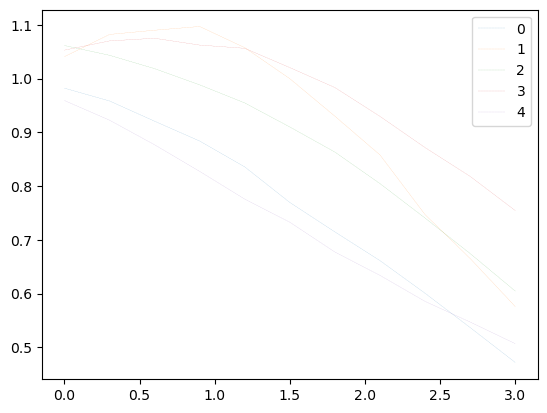

In [11]:
total_set=5
times1=delta_t*np.arange(n+1)
OTOC=np.zeros((total_set,n+1))
Ctilde=np.zeros((total_set,n+1))
finite_OTOC=np.zeros((total_set,n+1))


Wavg_val=[]
Wstd=[]
Vavg_val=[]
Vstd=[]

for i in range(n+1): # 
        W=np.zeros(random_run)
        V=np.zeros(random_run)
        myH=np.zeros(random_run)
        
        for j in range(random_run):
            #index=2*i*random_run
            index=2*i*random_run
            
            #print("index temp",index+2*j)
            temp_result1=all_result[index+2*j]
            temp_result2=all_result[index+2*j+1]       
            W[j]=calc_sigmaz(temp_result1,myshots)
            V[j]=calc_sigmaz(temp_result2,myshots)
            myH[j]=compute_H(np.array(Operator(my_unitary_ckt_list[j]).data),np.array(syk_op.data) )
       
        print("mean",i,np.mean(myH))

            #print(myH[j])
        
        mydata=np.transpose([W,V,myH])
        df_test=pd.DataFrame(mydata)
        #df_test.to_csv('benchmarking_localsim_ckt_data_instance_id_%d_randomrun_%d_20000shots' %(instance_id,random_run),sep='\t',header=False,index=False,mode='w')
        df_test.to_csv("WVHdata_beta/simulated_protocol%d_WVdata_tn%d_dt%0.1f_random_run%d_shots%d"\
                       %(instance_id,i,delta_t,random_run,myshots),sep='\t',header=False,index=False,mode='w')
   

        OTOC_t=[]
        myset_length=random_run//total_set
        
        for k in range(total_set):
            temp=calculate_infinite_temp_otoc(W[k*myset_length:(k+1)*myset_length],V[k*myset_length:(k+1)*myset_length],0)
            OTOC_t.append(temp)
        
        OTOC[:,i]=OTOC_t
        #print(i,OTOC[:,i])
        
        Ctilde_t=[]
        
        for k in range(total_set):
            temp=calculate_ctilde(W[k*myset_length:(k+1)*myset_length],V[k*myset_length:(k+1)*myset_length],\
                                 myH[k*myset_length:(k+1)*myset_length],0)
            Ctilde_t.append(temp)
            #print(k,Ctilde_t)
        
        Ctilde[:,i]=Ctilde_t
        #break

    
        
        
        
        

            
jk_100=[]
jkerr_100=[]

    
if total_set!=1:
    for i in range(len(finite_OTOC)):
        for j in range(len(finite_OTOC[0])):
            finite_OTOC[i][j]=OTOC[i][j]- 0.5*mybeta*(mmax+1)*(mmax+2) * Ctilde[i][j]
        
    print("deviation from the infinite temp OTOC *****")
    array_to_latex(finite_OTOC-OTOC)
    
                                           
    jk_100,jkerr_100=jk_arrays(finite_OTOC)   
    
    
    for i in range(len(finite_OTOC)):
        plt.plot(times1,finite_OTOC[i,:],ls='--',mfc='None',lw='0.1',label=r'%d'%i) 

else:
    for i in range(len(finite_OTOC)):
        for j in range(len(finite_OTOC[0])):
            finite_OTOC[i][j]=OTOC[i][j]- 0.5*mybeta*(mmax+1)*(mmax+2) * Ctilde[i][j]
            
    jk_100=finite_OTOC[0,:]
    jkerr_100=np.zeros(len(jk_100))
    print("*********",jk_100)


plt.legend()
#plt.plot(times2,OTOC_ED,'ok',ms='5') 


                                           
#plt.errorbar(times1,jk_100,jkerr_100,fmt='s',c='r',capsize=5)

print(jk_100)

In [12]:
instance_id
mybeta
#EDval=np.array([0.05409897, 0.04838817, 0.03864442, 0.02730182, 0.01710506,
#       0.01032511, 0.0081451 , 0.01039859, 0.01572249, 0.02205179,
#       0.02727905]) # beta 0.4

ED_filename='ED_id%d_beta%0.1f_dt%0.1f'%(instance_id,mybeta,delta_t)
print(ED_filename)
X=np.array(pd.read_csv(ED_filename,sep='\s+',header=None,index_col=False))
EDtime=X[:,0]
EDval=X[:,1]
jk_100


3

0.9

ED_id3_beta0.9_dt0.3


[1.0192301761128573,
 1.015251371019384,
 0.9961393495285573,
 0.9716791165626855,
 0.935922961979118,
 0.88640628870271,
 0.8336246047675188,
 0.7773740486062903,
 0.7089176553924303,
 0.64822204253055,
 0.5826314777492012]

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'time, $t$')

Text(0, 0.5, '$F_{10}(t)$')

Text(0.5, 1.0, '$J^2$=1.0, $N_U$=200, $\\beta$=0.9')

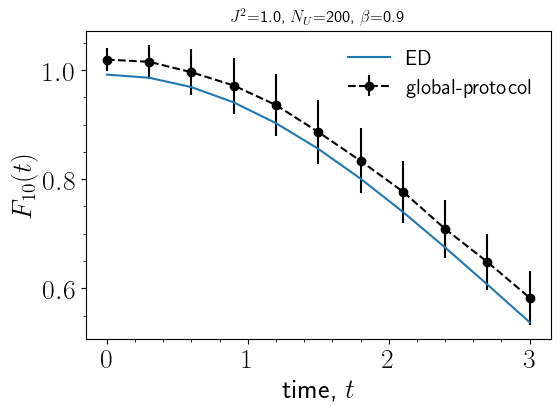

In [13]:
plt.rc('text',usetex=True)
fig, ax = plt.subplots(facecolor='w',figsize=(6,4))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.minorticks_on()

plt.errorbar(np.array(times1),np.array(jk_100),jkerr_100,marker='o',c='k',ls='--',label='global-protocol') 
plt.plot(EDtime,EDval,label=r'ED')
plt.xlabel(r'time, $t$',fontsize=20)
plt.ylabel(r'$F_{%d%d}(t)$'%(Wqubit,Vqubit),fontsize=20)
plt.legend(loc='best',fontsize=15,frameon=False)
plt.title(r'$J^2$=%0.1f, $N_U$=%d, $\beta$=%0.1f'%(Jsqr, random_run,mybeta))
plt.savefig(r'beta%0.1f_simulated_protocol_%d_dt%0.1f_random_run%d_shots%d.png' %(mybeta,instance_id,delta_t,random_run,myshots),bbox_inches='tight')

In [14]:
sim_prot_val=np.array(jk_100)
mydata=np.transpose([times1,sim_prot_val,jkerr_100])
df_test=pd.DataFrame(mydata)
df_test.to_csv('ckt_beta%0.1f_instance_id_%d_randomrun_%d_20000shots' %(mybeta,instance_id,random_run),sep='\t',header=False,index=False,mode='w')


In [15]:
print(datetime.datetime.now())

2024-02-08 01:54:13.730963


In [16]:
all_instance_plot=0
if all_instance_plot:
    instance_id_array=np.arange(1,11)

    otoc_arr=[]
    otocerr_arr=[]

    for instance_id in instance_id_array:
        filename='ckt_instance_data_N8_1/ckt_data_instance_id_%d'%instance_id
        Xtemp=np.array(pd.read_csv(filename,sep='\t',header=None,index_col=None)   ) 
        time=Xtemp[:,0]
        #print(Xtemp[:,0])
        #print(Xtemp[:,1])
        
        
        otoc_arr.append(Xtemp[:,1])
        otocerr_arr.append(Xtemp[:,2])
        plt.errorbar(time,Xtemp[:,1],Xtemp[:,2],label=r'%d'%instance_id)

    otoc_arr2=np.array(otoc_arr)
    otoc_avg=np.mean(otoc_arr2,0)
    
    otocerr_arr2=np.array(otocerr_arr)
    otocerr_avg=np.mean(otocerr_arr2,0)
    
    plt.errorbar(time,otoc_avg,otocerr_avg,marker='x',c='r',ms=20)
    #plt.savefig(r'ckt_instance_data_N8_1/all_instance%d.png' %len(instance_id_array),bbox_inches='tight')
    plt.legend(loc='best',fontsize=15,frameon=False)
    
    plt.rc('text',usetex=True)
    fig, ax = plt.subplots(facecolor='w',figsize=(6,4))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.minorticks_on()
    plt.errorbar(time,otoc_avg,otocerr_avg,marker='v',c='k',ms=5,capsize=5)
    plt.xlabel(r'time, $t$',fontsize=20)
    plt.ylabel(r'$F_{%d%d}(t)$'%(Wqubit,Vqubit),fontsize=20)
    plt.legend(loc='best',fontsize=15,frameon=False)
    plt.title(r'$J^2$=%0.1f, $N_U$=%d'%(Jsqr, random_run))
    #plt.savefig(r'ckt_instance_data_N8_1/total_instance%d.png' %len(instance_id_array),bbox_inches='tight')
